<a href="https://colab.research.google.com/github/seopbo/nlp_tutorials/blob/main/single_text_classification_(nsmc)_LoRa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Single text classification - LoRa
[LoRA: Low-Rank Adaptation of Large Language Models](https://arxiv.org/abs/2106.09685)를 GPT에 적용합니다.

- pre-trained language model로는 `skt/kogpt2-base-v2`를 사용합니다.
  - https://huggingface.co/skt/kogpt2-base-v2
- single text classification task를 수행하는 예시 데이터셋으로는 `nsmc`를 사용합니다.
  - https://huggingface.co/datasets/nsmc

## Setup
어떠한 GPU가 할당되었는 지 아래의 코드 셀을 실행함으로써 확인할 수 있습니다.

In [5]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)

if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

Tue Dec 28 04:58:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

아래의 코드 셀을 실행함으로써 본 노트북을 실행하기위한 library를 install하고 load합니다.

In [6]:
!pip install torch
!pip install transformers
!pip install datasets
!pip install -U scikit-learn

import torch
import transformers
import datasets

## Data preprocessing
1. `skt/kogpt2-base-v2`가 사용한 subword tokenizer를 load합니다.
2. `datasets` library를 이용하여 `nsmc`를 load합니다.
3. 1의 subword tokenizer를 이용 `nsmc`의 data를 single text classification을 수행할 수 있는 형태, train example로 transform합니다.
  - `<s> tok 1 ... tok N </s>`로 만들고, 이를 list_of_integers로 transform합니다.

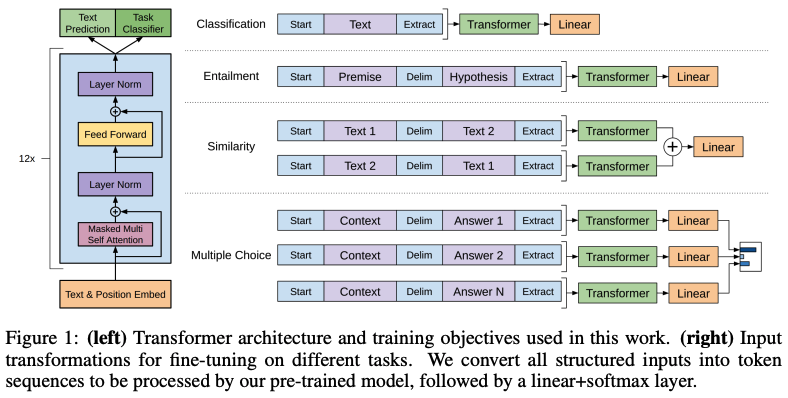

`nsmc`를 load하고, `train_ds`, `valid_ds`, `test_ds`를 생성합니다

In [7]:
from datasets import load_dataset

cs = load_dataset("nsmc", split="train")
cs = cs.train_test_split(0.1)
test_cs = load_dataset("nsmc", split="test")
train_cs = cs["train"]
valid_cs = cs["test"]

Downloading:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/807 [00:00<?, ?B/s]

Using custom data configuration default


  0%|          | 0/2 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/6.33M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.12M [00:00<?, ?B/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset nsmc downloaded and prepared to /root/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3. Subsequent calls will reuse this data.


Using custom data configuration default
Reusing dataset nsmc (/root/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3)


transform을 위한 함수를 정의하고 적용합니다. 먼저 `skt/kogpt2-base-v2`가 사용하는 subword tokenizer의 special tokens들을 확인합니다.

In [8]:
from transformers import GPT2TokenizerFast, GPT2Config

test_tokenizer = GPT2TokenizerFast.from_pretrained("skt/kogpt2-base-v2")
print(test_tokenizer.convert_ids_to_tokens(0))
print(test_tokenizer.convert_ids_to_tokens(1))
print(test_tokenizer.convert_ids_to_tokens(2))
print(test_tokenizer.convert_ids_to_tokens(3))
print(test_tokenizer.convert_ids_to_tokens(4))
print(test_tokenizer.convert_ids_to_tokens(5))

Downloading:   0%|          | 0.00/2.69M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.98k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


<s>
</s>
<usr>
<pad>
<sys>
<unk>


Figure 1의 classification 유형과 동일하게 처리하기위해서, `build_inputs_with_special_tokens` method를 overriding합니다. `build_inputs_with_special_tokens`를 overriding하면 `prepare_for_model` method 사용 시 그 변경사항이 반영됩니다.

In [10]:
from transformers import GPT2TokenizerFast, GPT2Config


class CustomGPT2TokenizerFast(GPT2TokenizerFast):
    def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
        """
        Build model inputs from a sequence or a pair of sequence for sequence classification tasks by concatenating and
        adding special tokens. A GPT sequence has the following format:

        - single sequence: ``<s> X </s>``
        - pair of sequences: ``<s> A </s> B </s>``

        Args:
            token_ids_0 (:obj:`List[int]`):
                List of IDs to which the special tokens will be added.
            token_ids_1 (:obj:`List[int]`, `optional`):
                Optional second list of IDs for sequence pairs.

        Returns:
            :obj:`List[int]`: List of `input IDs <../glossary.html#input-ids>`__ with the appropriate special tokens.
        """
        output = [tokenizer.bos_token_id] + token_ids_0 + [tokenizer.eos_token_id]

        if token_ids_1:
            output += token_ids_1 + [tokenizer.eos_token_id]

        return output

In [11]:
tokenizer = CustomGPT2TokenizerFast.from_pretrained("skt/kogpt2-base-v2")
tokenizer.pad_token = "<pad>"
tokenizer.unk_token = "<unk>"
tokenizer.bos_token = "<s>"
tokenizer.eos_token = "</s>"
config = GPT2Config.from_pretrained("skt/kogpt2-base-v2")

print(tokenizer.__class__)
print(config.__class__)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'CustomGPT2TokenizerFast'.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


<class '__main__.CustomGPT2TokenizerFast'>
<class 'transformers.models.gpt2.configuration_gpt2.GPT2Config'>


`__call__` method를 사용하지않고 단계적으로 `tokenize`, `convert_tokens_to_ids`, `prepare_for_model` method를 이용하여, `transform` function을 구현합니다.

In [12]:
from typing import Union, List, Dict


def transform(sentences: Union[str, List[str]], tokenizer) -> Dict[str, List[List[int]]]:
    if not isinstance(sentences, list):
        sentences = [sentences]
    dicf_of_training_examples: Dict[str, List[List[int]]] = {}

    for sentence in sentences:
        list_of_tokens = tokenizer.tokenize(sentence)
        list_of_ids = tokenizer.convert_tokens_to_ids(list_of_tokens)
        training_example = tokenizer.prepare_for_model(list_of_ids, add_special_tokens=True, padding=False, truncation=False)

        for key in training_example.keys():
            if key not in dicf_of_training_examples:
                dicf_of_training_examples.setdefault(key, [])
            dicf_of_training_examples[key].append(training_example[key])
    return dicf_of_training_examples

samples = train_cs[:2]
transformed_samples = transform(samples["document"], tokenizer)

print(samples)
print(transformed_samples)

{'id': ['8852339', '8694184'], 'document': ['평점이왜이렇게낮지?난 이거 또다운받고있다.3번째...정말잼있던데...끝에 견자단하고 대빵하고싸울땐 정말 가슴이뜨거워졌다.난정말로 잼있게봤다...최근댓글이니 내가 알바아닌줄은 알거다.', '재미없습니다 그리고 신음 소리땜에 당황했네요 아 물런 전 21살 영화가 참 재미없어보였는데 평점들 보고 재밌구나 하고 봤는데 젠장 재수없게 속았네요 이런게 도대체 뭐가 재밌다는건지 망할만한 영화였습니다 전 공짜로봐서다행입니다 이걸돈내고보면미친년'], 'label': [1, 0]}
{'input_ids': [[0, 9195, 10836, 8075, 8146, 10431, 7067, 8263, 406, 7058, 9018, 6853, 9108, 19012, 13372, 8155, 9016, 394, 10636, 29045, 8194, 7492, 8174, 8155, 7210, 7220, 29045, 7047, 8022, 9904, 8159, 7185, 9038, 9026, 7711, 9038, 7899, 8095, 7314, 29205, 42045, 7352, 6853, 8102, 34692, 7058, 8194, 14504, 739, 8174, 18479, 7662, 9016, 9705, 8393, 6949, 7204, 6951, 36609, 17582, 34790, 7965, 7174, 44852, 9181, 6853, 9016, 1], [0, 18767, 8015, 16913, 7182, 9394, 9084, 8139, 12867, 7316, 8022, 38491, 8718, 7098, 8084, 9050, 9169, 7399, 9034, 10742, 7760, 9097, 10444, 9338, 18767, 8015, 8006, 7652, 28683, 9195, 8191, 7285, 10056, 9150, 7592, 12226, 9676, 739, 7662, 9668, 43002, 8168, 9

In [13]:
train_ds = train_cs.map(lambda data: transform(data["document"], tokenizer), remove_columns=["id", "document"], batched=True).rename_column("label", "labels")
valid_ds = valid_cs.map(lambda data: transform(data["document"], tokenizer), remove_columns=["id", "document"], batched=True).rename_column("label", "labels")
test_ds = test_cs.map(lambda data: transform(data["document"], tokenizer), remove_columns=["id", "document"], batched=True).rename_column("label", "labels")

  0%|          | 0/135 [00:00<?, ?ba/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/50 [00:00<?, ?ba/s]

## Prepare model
single text classification을 수행하기위해서 `skt/kogpt2-base-v2`를 load해야합니다. 단 LoRa를 위한 weight를 정의하기위해서 custom class를 작성하는 것이 필요합니다.

### 1. `GPT2Attention`을 subclassing하여 `GPT2AttentionWithLoRa`를 구현
`GPT2Attention`을 상속하여 `__init__`과 `forward` method를 overriding합니다.



In [16]:
from torch import nn
from transformers.models.gpt2.modeling_gpt2 import GPT2Attention
from transformers.modeling_utils import Conv1D


class GPT2AttentionWithLoRa(GPT2Attention):
    def __init__(self, config, is_cross_attention=False, layer_idx=None):
        super().__init__(config, is_cross_attention=False, layer_idx=None)
        self.c_attn_lora = nn.Sequential(
            Conv1D(4, self.embed_dim),
            Conv1D(3 * self.embed_dim, 4),        
        )
        self.c_proj_lora = nn.Sequential(
            Conv1D(4, self.embed_dim),
            Conv1D(self.embed_dim, 4),
        )

    def forward(
        self,
        hidden_states,
        layer_past=None,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        use_cache=False,
        output_attentions=False,
        ):
        if encoder_hidden_states is not None:
            if not hasattr(self, "q_attn"):
                raise ValueError(
                    "If class is used as cross attention, the weights `q_attn` have to be defined. "
                    "Please make sure to instantiate class with `GPT2Attention(..., is_cross_attention=True)`."
                )

            query = self.q_attn(hidden_states)
            key, value = self.c_attn(encoder_hidden_states).split(self.split_size, dim=2)
            attention_mask = encoder_attention_mask
        else:
            query_orig, key_orig, value_orig = self.c_attn(hidden_states).split(self.split_size, dim=2)
            # Added codes
            query_adpt, key_adpt, value_adpt = self.c_attn_lora(hidden_states).split(self.split_size, dim=2)
            query = query_orig + query_adpt
            key = key_orig + key_adpt
            value = value_orig + value_adpt

        query = self._split_heads(query, self.num_heads, self.head_dim)
        key = self._split_heads(key, self.num_heads, self.head_dim)
        value = self._split_heads(value, self.num_heads, self.head_dim)

        if layer_past is not None:
            past_key, past_value = layer_past
            key = torch.cat((past_key, key), dim=-2)
            value = torch.cat((past_value, value), dim=-2)

        if use_cache is True:
            present = (key, value)
        else:
            present = None

        if self.reorder_and_upcast_attn:
            attn_output, attn_weights = self._upcast_and_reordered_attn(query, key, value, attention_mask, head_mask)
        else:
            attn_output, attn_weights = self._attn(query, key, value, attention_mask, head_mask)

        attn_output_raw = self._merge_heads(attn_output, self.num_heads, self.head_dim)
        attn_output_orig = self.c_proj(attn_output_raw)

        # Added codes
        attn_output_adpt = self.c_proj_lora(attn_output_raw)
        attn_output = attn_output_orig + attn_output_adpt

        attn_output = self.resid_dropout(attn_output)

        outputs = (attn_output, present)
        if output_attentions:
            outputs += (attn_weights,)

        return outputs  # a, present, (attentions)

### 2. `GPT2Attention`을 subclassing하여 `GPT2BlockWithLoRa`를 구현
`GPT2Block`을 상속하여 `__init__`을 overriding합니다.

In [17]:
from torch import nn
from transformers.models.gpt2.modeling_gpt2 import GPT2Block, GPT2MLP
from transformers.modeling_utils import Conv1D


class GPT2BlockWithLoRa(GPT2Block):
    def __init__(self, config, layer_idx=None):
        super().__init__(config, layer_idx)
        self.attn = GPT2AttentionWithLoRa(config, layer_idx=layer_idx)

### 3. `GPT2Model`을 subclassing하여 `GPT2ModelkWithLoRa`를 구현
`GPT2Model`을 상속하여 `__init__`을 overriding합니다.

In [18]:
from torch import nn
from transformers.models.gpt2.modeling_gpt2 import GPT2Model


class GPT2ModelWithLoRa(GPT2Model):
    def __init__(self, config):
        super().__init__(config)
        self.h = nn.ModuleList([GPT2BlockWithLoRa(config, layer_idx=i) for i in range(config.num_hidden_layers)])

### 4, `GPT2ForSequenceClassification`을 subclassing하여 `GPT2ForSequenceClassificationWithLoRa`를 구현
`GPT2ForSequenceClassification`을 상속하여 `__init__`을 overriding합니다.

In [19]:
from torch import nn
from transformers.models.gpt2.modeling_gpt2 import GPT2ForSequenceClassification
from transformers.modeling_utils import Conv1D


class GPT2ForSequenceClassificationWithLoRa(GPT2ForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)
        self.transformer = GPT2ModelWithLoRa(config)

### lora 관련 weight만 train 되도록 설정

In [20]:
model = GPT2ForSequenceClassificationWithLoRa.from_pretrained("skt/kogpt2-base-v2", num_labels=2)

Downloading:   0%|          | 0.00/490M [00:00<?, ?B/s]

Some weights of the model checkpoint at skt/kogpt2-base-v2 were not used when initializing GPT2ForSequenceClassificationWithLoRa: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassificationWithLoRa from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassificationWithLoRa from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassificationWithLoRa were not initialized from the model checkpoint at skt/kogpt2-base-v2 and are newly initialized: ['transformer.h.4.attn.c_attn_lora.1.bias', 'transformer.h.10.attn.c_proj_lora.1.weight', 'transformer.h.9.attn.c_attn_lora.0.weight', 'transformer.h.1.attn.c_attn_lora.1.weight', 'transformer

In [22]:
for named_parameter in model.named_parameters():
    if "lora" in named_parameter[0]:
        continue
    named_parameter[-1].requires_grad_(False)


## Training model
`Trainer` class를 이용하여 train합니다.

- https://huggingface.co/transformers/custom_datasets.html?highlight=trainer#fine-tuning-with-trainer

In [24]:
import numpy as np
from transformers.data.data_collator import DataCollatorWithPadding
from sklearn.metrics import accuracy_score


def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    return {"accuracy": accuracy} 


batchify = DataCollatorWithPadding(
    tokenizer = tokenizer,
    padding = "longest",   
)

In [25]:
# mini-batch 구성확인
batchify(train_ds[:2])

{'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'input_ids': tensor([[    0,  9195, 10836,  8075,  8146, 10431,  7067,  8263,   406,  7058,
          9018,  6853,  9108, 19012, 13372,  8155,  9016,   394, 10636, 29045,
          8194,  7492,  8174,  8155,  7210,  7220, 29045,  7047,  8022,  9904,
          8159,  7185,  9038,  9026,  7711,  9038,  7899,  8095,  7314, 29205,
         42045,  7352,  6853,  8102, 34692,  705

In [26]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="steps",
    eval_steps=1000,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=1e-4,
    weight_decay=0.01,
    adam_beta1=.9,
    adam_beta2=.95,
    adam_epsilon=1e-8,
    max_grad_norm=1.,
    num_train_epochs=2,    
    lr_scheduler_type="linear",
    warmup_steps=100,
    logging_dir='./logs',
    logging_strategy="steps",
    logging_first_step=True,
    logging_steps=100,
    save_strategy="epoch",
    seed=42,
    dataloader_drop_last=False,
    dataloader_num_workers=2
)

trainer = Trainer(
  args=training_args,
  data_collator=batchify,
  model=model,
  train_dataset=train_ds,
  eval_dataset=valid_ds,
  compute_metrics=compute_metrics
)

trainer.train()

***** Running training *****
  Num examples = 135000
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 8438


Step,Training Loss,Validation Loss,Accuracy
1000,0.401700,0.369838,0.838867
2000,0.372000,0.353159,0.846667
3000,0.344000,0.334871,0.859133
4000,0.348900,0.328381,0.858467
5000,0.336100,0.316054,0.864267
6000,0.322300,0.313498,0.865400
7000,0.330200,0.311452,0.866533
8000,0.326800,0.310423,0.866467


***** Running Evaluation *****
  Num examples = 15000
  Batch size = 32
***** Running Evaluation *****
  Num examples = 15000
  Batch size = 32
***** Running Evaluation *****
  Num examples = 15000
  Batch size = 32
***** Running Evaluation *****
  Num examples = 15000
  Batch size = 32
Saving model checkpoint to ./results/checkpoint-4219
Configuration saved in ./results/checkpoint-4219/config.json
Model weights saved in ./results/checkpoint-4219/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 15000
  Batch size = 32
***** Running Evaluation *****
  Num examples = 15000
  Batch size = 32
***** Running Evaluation *****
  Num examples = 15000
  Batch size = 32
***** Running Evaluation *****
  Num examples = 15000
  Batch size = 32
Saving model checkpoint to ./results/checkpoint-8438
Configuration saved in ./results/checkpoint-8438/config.json
Model weights saved in ./results/checkpoint-8438/pytorch_model.bin


Training completed. Do not forget to share your model on hug

TrainOutput(global_step=8438, training_loss=0.3597918173435543, metrics={'train_runtime': 2013.1715, 'train_samples_per_second': 134.117, 'train_steps_per_second': 4.191, 'total_flos': 9218401540577280.0, 'train_loss': 0.3597918173435543, 'epoch': 2.0})

In [27]:
trainer.evaluate(test_ds)

***** Running Evaluation *****
  Num examples = 50000
  Batch size = 32


{'epoch': 2.0,
 'eval_accuracy': 0.86342,
 'eval_loss': 0.3234514594078064,
 'eval_runtime': 139.3975,
 'eval_samples_per_second': 358.686,
 'eval_steps_per_second': 11.213}